In [7]:
import pandas as pd
import numpy as np
from numpy.random import normal, uniform
from numpy.linalg import norm as numpy_norm
from scipy.stats import norm as scipy_norm
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
np.random.seed(7)

In [8]:
def ppf(px, h):
    # Sort px and prepare evaluation points
    px_sorted = np.sort(px)
    xeval = np.linspace(px_sorted[0], px_sorted[-1], num=len(px))

    # Perform kernel density estimation with Epanechnikov kernel
    kde = KernelDensity(bandwidth=h, kernel='epanechnikov')
    kde.fit(px_sorted.reshape(-1, 1))
    
    # Evaluate the density
    log_dens = kde.score_samples(xeval.reshape(-1, 1))
    dens = np.exp(log_dens)
    
    # Calculate the mean of the densities
    ind = np.mean(dens)
    
    return ind

In [9]:
def ppexample(x, h, n):
    # Create an evaluation grid for density estimation.
    xg = np.arange(-4, 4.1, 0.1).reshape(-1, 1)

    # Generate and normalize a random starting vector.
    p = normal(size=x.shape[1])
    p /= numpy_norm(p)
    
    # Project data onto the starting vector and calculate initial index.
    xp = x@p
    imin = ppf(xp, h)
    imax = imin
    
    # Set up 'xi' points for KDE, apply transformations, and estimate density.
    xi = np.column_stack((xp, uniform(0, 1, size=len(xp))))
    xi[:, 1] = -0.11 - 0.08 * xi[:, 1] # Adjust y-values
    kde_xi = KernelDensity(bandwidth=h, kernel='epanechnikov')
    kde_xi.fit(xi[:, 0].reshape(-1, 1))
    log_dens_xi = kde_xi.score_samples(xg)
    fi = np.column_stack((xg.flatten(), np.exp(log_dens_xi)))


    # Set up 'xa' points for KDE, apply transformations, and estimate density.
    xa = np.column_stack((xp, uniform(0, 1, size=len(xp))))
    xa[:, 1] = -0.01 - 0.08 * xa[:, 1] # Adjust y-values
    kde_xa = KernelDensity(bandwidth=h, kernel='epanechnikov')
    kde_xa.fit(xa[:, 0].reshape(-1, 1))
    log_dens_xa = kde_xa.score_samples(xg)
    fa = np.column_stack((xg.flatten(), np.exp(log_dens_xa)))

    # Search for better projection vector
    i = 0
    pmin = 1
    pmax = 1
    inds = [1/np.sqrt(4 * np.pi), imax]
    pind = np.column_stack((np.arange(1, len(inds) + 1), inds)) 
    mini = None 

    while i < n:
        i += 1
        p = normal(size=x.shape[1])
        p /= numpy_norm(p)
        xp = x@p
        ind = ppf(xp, h)
        inds.append(ind)
        pind = np.column_stack((np.arange(1, len(inds) + 1), inds))
        cind = np.array([2] + [1] * (len(inds) - 1))
        cind[np.argmax(inds)] = 4
        cind[np.argmin(inds)] = 1
        cind[0] = 2
        
        # If the new index is a new maximum, update and recalculate densities.
        if ind > imax:
            imax = ind
            xa = np.column_stack((xp, uniform(0, 1, size=len(xp))))
            xa[:, 1] = -0.01 - 0.08 * xa[:, 1]
            kde_xa = KernelDensity(bandwidth=h, kernel='epanechnikov').fit(xa[:, 0].reshape(-1, 1))
            log_dens_xa = kde_xa.score_samples(xg)
            fa = np.column_stack((xg.flatten(), np.exp(log_dens_xa)))
            
        # If the new index is a new minimum, update and recalculate densities.
        if ind < imin:
            imin = ind
            xi = np.column_stack((xp, uniform(0, 1, size=len(xp))))
            xi[:, 1] = -0.11 - 0.08 * xi[:, 1]
            kde_xi = KernelDensity(bandwidth=h, kernel='epanechnikov').fit(xi[:, 0].reshape(-1, 1))
            log_dens_xi = kde_xi.score_samples(xg)
            fi = np.column_stack((xg.flatten(), np.exp(log_dens_xi)))

            pmax = i
            mini = p

    # Return a dictionary of results
    return {
        'xa': xa, 
        'xi': xi, 
        'fa': fa, 
        'fi': fi, 
        'pind': pind, 
        'cind': cind
    }

In [10]:
def sphere(x):
    # Subtract column means to center data.
    x_centered = x - np.mean(x, axis=0)

    # Compute covariance matrix of centered data.
    cov_matrix = np.cov(x_centered, rowvar=False)

    # SVD of covariance matrix.
    u, s, vh = np.linalg.svd(cov_matrix)

    # Scale u by inverse square root of s.
    s_matrix = np.diag(1 / np.sqrt(s))
    transformation_matrix = np.dot(u, s_matrix)

    # Transform data using scaled matrix.
    x_sphered = np.dot(x_centered, transformation_matrix)
    
    return x_sphered

In [11]:
# Load data
x = pd.read_table("bank2.dat", delim_whitespace=True, header=None)
x_transformed = sphere(x)

h = 2.62 * x_transformed.shape[0] ** (-1/5) # Calculate the bandwidth
n = 50 # Set the number of projections

inde = ppexample(x_transformed, h, n)

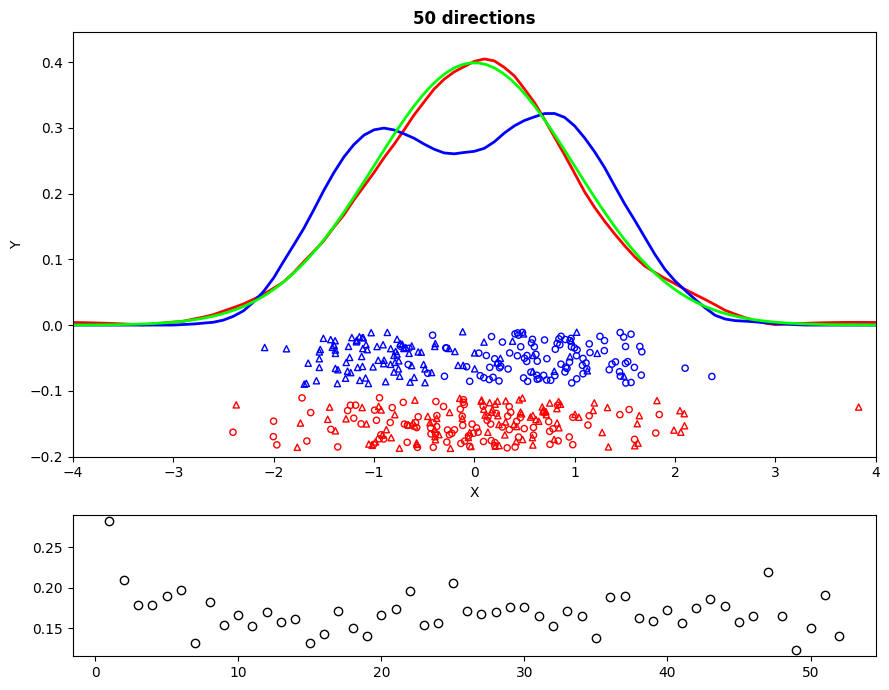

In [13]:
# Plotting
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(9, 7))

# First subplot
ax = axs[0]
ax.scatter(inde['xa'][:100, 0], inde['xa'][:100, 1], facecolors='none', edgecolors='b', marker='o', s=20)  # Blue hollow circles
ax.scatter(inde['xa'][100:, 0], inde['xa'][100:, 1], facecolors='none', edgecolors='b', marker='^', s=20)  # Blue hollow triangles
ax.scatter(inde['xi'][:100, 0], inde['xi'][:100, 1], facecolors='none', edgecolors='r', marker='o', s=20)  # Red hollow circles
ax.scatter(inde['xi'][100:, 0], inde['xi'][100:, 1], facecolors='none', edgecolors='r', marker='^', s=20)  # Red hollow triangles
ax.plot(inde['fi'][:, 0], inde['fi'][:, 1], 'r-', linewidth=2)  # Red line for fi density
ax.plot(inde['fa'][:, 0], inde['fa'][:, 1], 'b-', linewidth=2)  # Blue line for fa density
ax.plot(np.linspace(-4, 4, 100), scipy_norm.pdf(np.linspace(-4, 4, 100)), 'lime', linewidth=2)  # Green line for standard normal
ax.set_xlim(-4, 4)
ax.set_ylim(-0.2, 1.1*max(np.max(inde['fi'][:, 1]), np.max(inde['fa'][:, 1])))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('50 directions', fontweight='bold')

# Second subplot
ax = axs[1]
ax.plot(inde['pind'][:, 0], inde['pind'][:, 1], 'ko', markerfacecolor='none')  # Black points

# Show the plot
plt.tight_layout()
plt.show()